In [1]:
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import cv2
from jupyterplot import ProgressPlot

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [3]:
# importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self,path,annatation,transform=None):
        self.transform=transform
        self.path=path
        self.annatation=annatation
        #print(path)
        df=pd.read_csv(annatation)
        images_dir=list()
        labels=list()
        images=list()
        for i,j in tqdm(enumerate(df['example_path'])):
            x=os.path.join(self.path,j)
            label=df['label'][i]
            labels.append(label)
            images_dir.append(x)
            image=cv2.imread(x)
            images.append(image)
            # data augumentation 
            if label==1:
                rotated =rotate(image, angle=45, mode = 'wrap')
                images.append(rotated)
                labels.append(label)
                transform = AffineTransform(translation=(25,25))
                wrapShift = warp(image,transform,mode='wrap')
                images.append(wrapShift)
                labels.append(label)
                flipUD = np.flipud(image).copy()
                images.append(flipUD)
                labels.append(label)
            elif label==2:
                rotated =rotate(image, angle=45, mode = 'wrap')
                images.append(rotated)
                labels.append(label)
                flipUD = np.flipud(image).copy()
                images.append(flipUD)
                labels.append(label)
                
        self.images_dir=images_dir
        self.labels=labels
        self.images=images
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #image=cv2.imread(self.images_dir[idx])
        target=self.labels[idx]
        image=self.images[idx]
        #print(target)
        if self.transform is not None:
            image=self.transform(image)
            target=torch.tensor(np.eye(3)[target])
        return image,target

In [5]:
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((300,300)),
  #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [6]:
dataset=CustomImageDataset(path=r"E:\hackathon\train_test_data",annatation=r"E:\hackathon\train.csv",transform=train_transforms)

1714it [00:32, 52.01it/s]


In [7]:
len(dataset)

3618

In [8]:
training_set, test_set = torch.utils.data.random_split(dataset,[2894,724])
train_set,validation_Set=torch.utils.data.random_split(training_set,[2605,289])

In [9]:
train_dataloader = DataLoader(train_set, batch_size=16,shuffle=True)
validation_loader=DataLoader(validation_Set, batch_size=1,shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1,shuffle=True)

In [10]:
import torch.nn as nn
from torchsummary import summary

class MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = MobileNetV1(3,3)
model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [32]:
import numpy as np
epochs = 5
min_valid_loss = np.inf
for e in range(epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for images,labels in tqdm(train_dataloader):
        if torch.cuda.is_available():
            images, labels = images.to(device).float(), labels.to(device)
        if torch.cuda.is_available():
            model.cuda()
        #labels = torch.eye(3)[labels].to(device)
        #print('imageshape:',images.shape,labels.shape,labels)
        optimizer.zero_grad()
        output = model(images)
        #print(output.shape,labels.shape)
        #labels = labels.to(torch.float32)
        loss = criterion(output,labels)
        
        #loss = criterion(outputs,labels.view(1, -1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()/20
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss}')
    model.eval()
    for images,labels in tqdm(validation_loader):
        if torch.cuda.is_available():
            images, labels = images.to(device).float(), labels.to(device)
        if torch.cuda.is_available():
            model.cuda()
        #labels = torch.eye(3)[labels].to(device)
        #print('imageshape:',images.shape,labels.shape,labels)
        optimizer.zero_grad()
        output = model(images)
        loss   =criterion(output,labels)
        loss=loss.item()

    print(f'Epoch {e+1} \t\t validation Loss: {loss}')

100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [05:05<00:00,  1.87s/it]


Epoch 1 		 Training Loss: 5.10210634746587


100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [00:12<00:00, 22.56it/s]


Epoch 1 		 validation Loss: 1.3291467428207397


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [05:07<00:00,  1.88s/it]


Epoch 2 		 Training Loss: 4.718218685404938


100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [00:12<00:00, 22.36it/s]


Epoch 2 		 validation Loss: 0.3930349051952362


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [05:04<00:00,  1.87s/it]


Epoch 3 		 Training Loss: 4.1623710175051185


100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [00:12<00:00, 22.25it/s]


Epoch 3 		 validation Loss: 0.02477329969406128


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [05:05<00:00,  1.87s/it]


Epoch 4 		 Training Loss: 3.978591630574228


100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [00:12<00:00, 22.58it/s]


Epoch 4 		 validation Loss: 0.031714022159576416


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [05:05<00:00,  1.87s/it]


Epoch 5 		 Training Loss: 3.6331827731114545


100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [00:13<00:00, 22.17it/s]

Epoch 5 		 validation Loss: 2.1276090145111084


In [33]:
model.eval()     # Optional when not using Model Specific layer
for images,labels in test_dataloader:
    if torch.cuda.is_available():
        images, labels = images.to(device).float(), labels.to(device)
    if torch.cuda.is_available():
        model.cuda()
    output = model(images)
    print(torch.argmax(output),torch.argmax(labels))

tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(1, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(1, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(1, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(1, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') t

In [34]:
ground_truth=[]
predection=[]
for img,label in tqdm(test_dataloader):
    output=model(img.to(device).float())
    target=label.to(device)
    #print(torch.argmax(output),torch.argmax(target))
    output=torch.argmax(output).data.cpu().numpy()
    target=torch.argmax(target).data.cpu().numpy()
    ground_truth.append(target)
    predection.append(output)

100%|████████████████████████████████████████████████████████████████████████████████| 724/724 [00:29<00:00, 24.94it/s]


In [35]:
#df1=pd.DataFrame({'ground_truth':ground_truth,'predection': predection})

In [36]:
from sklearn.metrics import confusion_matrix,classification_report,f1_score

In [37]:
#x=confusion_matrix(df1['ground_truth'],df1['predections'])
confusion_matrix=confusion_matrix(ground_truth, predection)

In [38]:
print(classification_report(ground_truth,predection))

              precision    recall  f1-score   support

           0       0.76      0.58      0.66       165
           1       0.76      0.24      0.36       156
           2       0.68      0.93      0.78       403

    accuracy                           0.70       724
   macro avg       0.73      0.58      0.60       724
weighted avg       0.71      0.70      0.66       724



In [39]:
f1_score(ground_truth,predection,average='macro')

0.6003459483883835

<AxesSubplot:>

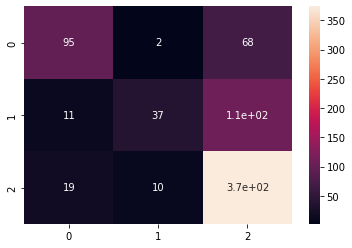

In [40]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True)

In [41]:
path=r"E:\hackathon\train_test_data\train_test_data\test"

In [42]:
class CustomImageDataset(Dataset):
    def __init__(self,path,transform=None):
        self.transform=transform
        self.path=path
        images_dir=list()
        for i in os.listdir(self.path):
            x=os.path.join(self.path,i)
            images_dir.append(x)
        self.images_dir=images_dir
    def __len__(self):
        return len(self.images_dir)
    def __getitem__(self, idx):
        image=cv2.imread(self.images_dir[idx])
        #print(target)
        if self.transform is not None:
            image=self.transform(image)
            directory=self.images_dir[idx]
        return image,directory

In [43]:
dataset=CustomImageDataset(path,train_transforms)

In [44]:
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((332,332)),
  #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [45]:
dataset_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, num_workers=0
)

In [46]:
"E:\hackathon\train_test_data\train_test_data\test\1.png"

'E:\\hackathon\train_test_data\train_test_data\test\x01.png'

In [48]:
predection=list()
path_img=list()
model.eval()
for i,j in dataset_loader:
    output=model(i.to(device).float())
    y=str(j)
    path_img.append((y[57:-7]))
    output=torch.argmax(output).data.cpu().numpy()
    predection.append(output)

In [53]:
df1=pd.DataFrame({'image_path':path_img,'predection':predection})

In [54]:
df1['predection']

0      2
1      0
2      2
3      2
4      2
      ..
630    2
631    2
632    0
633    2
634    2
Name: predection, Length: 635, dtype: object

In [52]:
predection

[array(2, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(2, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(2, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=

In [59]:
os.makedirs(r"E:\hackathon", exist_ok=True)  
df1.to_csv(r"E:\hackathon/predection.csv",index=False)  